In [3]:
import pickle
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

with open('data/20x20.pkl', 'rb') as f:
    data = pickle.load(f)
    
conditional_freq = data[0]
action_freq = data[1]

In [4]:
import random

random.seed(1)

def match(proposedList, comparisonList):
    intersect = set(proposedList).intersection(set(comparisonList))
    return len(list(intersect))/len(proposedList) # Percentage match

    
def score_proposal(proposal, conditional_freq, action_freq, ingredient_list, action_list):
    '''
    We expect proposal to be a list where the first element is an action, and the rest are ingredients
    '''
    action = proposal[0]
    isolated_ingredients = isolate_ingredients(proposal, ingredient_list)
    isolated_actions = isolate_actions(proposal, action_list)[1:]
    
    ingredient_score = 0
    for item in conditional_freq[action].items():
        ingredient_score += match(isolated_ingredients, item[0])
    ingredient_score /= sum(list(conditional_freq[action].values()))
    
    action_score = 0
    if len(isolated_actions) == 0:
        action_score = 1
    else:
        for item in action_freq[action].items():
            action_score += match(isolated_actions, item[0])
        action_score /= sum(list(action_freq[action].values()))
        
    return ingredient_score * action_score


def isolate_ingredients(proposal, ingredient_list):
    result = []
    for elem in proposal:
        if type(elem) == list:
            result.extend(isolate_ingredients(elem, ingredient_list))
        elif elem in ingredient_list:
            result.append(elem)
        else:
            pass
            # print(elem)
            
    return result

def isolate_actions(proposal, action_list):
    result = []
    for elem in proposal:
        if type(elem) == list:
            result.extend(isolate_actions(elem, action_list))
        elif elem in action_list:
            result.append(elem)
        else:
            pass
            # print(elem)
            
    return result

In [5]:
class Hypergraph:
    def __init__(self, ingredients, actions):
        '''
            self.hyperedges is a list of pairs whose first elemnent is the set containing the
            source vertices, and the second element is the set contianing the destination 
            vertices
        '''
        self.ingredients = ingredients
        self.actions = actions
        
        self.vertices = deepcopy(ingredients)
        self.available_vertices = deepcopy(ingredients)
        
        self.transitions = {}
        
    def propose_new_hyperedge(self):
        proposed_action = random.choice(list(action_freq.keys()))
        
        # Now, we pick a double or triple of available vertices
        if len(self.available_vertices) >= 3 and random.uniform(0, 1) < 0.3:
            k = 3
        else:
            k = 2
           
        vertices = random.sample(self.available_vertices, k=k)
        action = random.choice(self.actions)
        proposal = [action] + vertices
        
        return proposal
            
    def generate_over_samples(self):
        # First, we produce a distribution of scores given the current state of the hypergraph
        SAMPLES = 100
        data = []
        
        for i in range(100):
            proposal = self.propose_new_hyperedge()
            data.append(score_proposal(proposal, conditional_freq, action_freq, self.ingredients, self.actions))
        
        mean = np.mean(data)
        std = np.std(data)
        
        # We assume normal distribution since iid
        while True:
            proposal = self.propose_new_hyperedge()
            distn = scipy.stats.norm(mean, std)
            score = score_proposal(proposal, conditional_freq, action_freq, self.ingredients, self.actions)
            prob = distn.cdf(score)
            
            # Accept hyperedge
            if random.uniform(0, 1) <= prob:
                for item in proposal[1:]:
                    # print(item, proposal, self.available_vertices)
                    self.available_vertices.remove(item)
                
                self.available_vertices.append(proposal)
                break
        
            
    def complete(self):
        while len(self.available_vertices) != 1:
            self.generate_over_samples()
        
        return 

In [6]:
action_list = list(action_freq.keys())
ingredient_list = ['butter', 'onion', 'cream', 'honey', 'milk', 'mustard', 'water']

h = Hypergraph(deepcopy(ingredient_list), deepcopy(action_list))
h.complete()

In [7]:
h.available_vertices[0]

['Combine',
 'butter',
 ['Put', 'onion', ['Let', 'milk', 'water'], 'cream'],
 ['Heat', 'mustard', 'honey']]

## Generate full transition matrix

We now traverse through all possible states to determine that 'real' transition probabilities based on the
normalized score values on all possible outgoing edges

In [8]:
import itertools

# We're going to ditch the hypergraph class since it turns out we didn't need it as much as I thought

initial_ingredient_list = ['butter', 'cream', 'water']
initial_action_list = ['Mix', 'Combine', 'Pour']

vertices = deepcopy(initial_ingredient_list)
transitions = dict()

def stringify(L):
    output = "("
    for i in range(len(L)):
        if type(L[i]) == str:
            output += L[i]
        else:
            output += stringify(L[i])
        
        if i != len(L)-1:
            output += ', '
            
    output += ")"
    return output

def process_state(vertices):
    proposals = []
    scores = []
    
    # k = 3
    for combination in itertools.combinations(vertices, 3):
        for action in initial_action_list:
            proposal = [action] + list(combination)
            score = score_proposal(proposal, conditional_freq, action_freq, initial_ingredient_list,\
                                   initial_action_list)
            
            proposals.append(proposal)
            scores.append(score)
           
    # k = 2
    for combination in itertools.combinations(vertices, 2):
        for action in initial_action_list:
            proposal = [action] + list(combination)
            score = score_proposal(proposal, conditional_freq, action_freq,\
                                   initial_ingredient_list, initial_action_list)
            
            proposals.append(proposal)
            scores.append(score)

    string_ver = stringify(vertices)
    if string_ver not in transitions:
        transitions[string_ver] = []
            
    # Early return if we're in a final state
    if len(proposals) == 0:
        transitions[string_ver] = []
    
    score_sum = sum(scores)
        
    # Go through each transition
    for i, proposal in enumerate(proposals):
        vertex_copy = deepcopy(vertices)
        vertex_copy = [i for i in vertex_copy if i not in proposal]
        vertex_copy.append(proposal)
        
        transitions[string_ver].append((stringify(vertex_copy), scores[i]/score_sum))
        process_state(vertex_copy)
        
        
        
process_state(deepcopy(initial_ingredient_list))

In [9]:
states = list(transitions.keys())

# Get state -> index mapping for convenience
state_enumeration = dict()
for i in range(len(states)):
    state_enumeration[states[i]] = i

matrix = []

# Construct matrix with 0s
for i in range(len(state_enumeration)):
    matrix.append([0] * len(state_enumeration))
    
# Fill in the transition probabilities
for key in transitions:
    for pair in transitions[key]:
        source_idx = state_enumeration[key]
        dest_idx = state_enumeration[pair[0]]
        
        matrix[source_idx][dest_idx] = pair[1]
        
print(len(matrix))

40


## Data Visualization

['Combine', 'butter', ['Put', 'onion', ['Let', 'milk', 'water'], 'cream'], ['Heat', 'mustard', 'honey']]
strict graph "" {
	Combine -- butter;
	Combine -- Put;
	Combine -- Heat;
	Put -- onion;
	Put -- Let;
	Put -- cream;
	Let -- milk;
	Let -- water;
	Heat -- mustard;
	Heat -- honey;
}



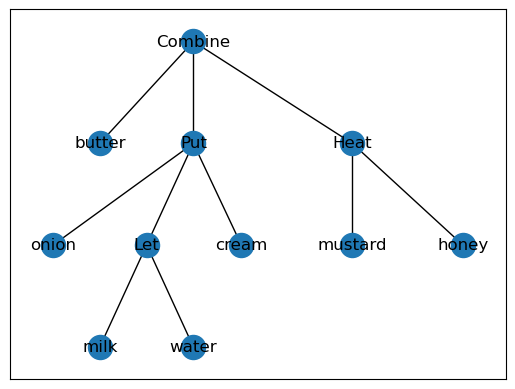

In [38]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph

tree = h.available_vertices[0]
G = nx.Graph()

print(tree)
def process_graph(tree, G):
    G.add_node(tree[0])
    for elem in tree[1:]:
        if type(elem) == list:
            node = process_graph(elem, G)
            G.add_edge(tree[0], node)
        else:
            G.add_node(elem)
            G.add_edge(tree[0], elem)
            
    return tree[0]

process_graph(tree, G)

A = to_agraph(G)
A.layout('dot')
A.draw('')

layout = graphviz_layout(G, prog="dot")
nx.draw_networkx(G, layout)